In [1]:
################################
# LIBRARIES
################################
import os
import sys
module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

from src.util import *
from src.frames import *
from src.stats import *
from src.plots import *

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from scipy.stats import f_oneway
from statsmodels.stats.multicomp import pairwise_tukeyhsd

%matplotlib inline
%load_ext autoreload
%autoreload 2

pd.options.mode.chained_assignment = None  # default='warn'

/opt/homebrew/lib/python3.9/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Down Middle Up

Simultaneous measurements above Odenplan T-station and on the middle of the platform Odenplan T-station. As well as simultaneuous measurements Odenplan T-station and Odenplan P-station.

**Timestamps**

8:20-8:30
- A-E ovanför marken
- 1-6 mitten av Odenplan T
    
8:35-8:40
- A-E mitten av Odenplan T
- 1-6 mitten av Odenplan P

In [2]:
# Set param [e.g. PM2.5 or NC2.5]
param = 'PM2.5'
unit = 'µg/m³'
date = '2021-10-29'

# figure folder
fig_folder = '../results/down_middle_up'

In [3]:
# Store all raw session dataframes in array
dmu_dfs = []

# Get session files in folder
folder = '../data/down_middle_up/'
session_files = sorted(os.listdir(folder))

for i, file_name in enumerate(session_files):

    # Read individual sensor data
    raw_df = pd.read_csv(folder + '/' + file_name, skiprows=1)
    raw_df['Sensor'] = str(file_name[0])
    raw_df['Timestamp'] = raw_df['Time'].apply(lambda x: format_time('2021-10-29', x) + timedelta(hours=2))

    # Add to list
    dmu_dfs.append(raw_df)

# Combine all sensor dfs into one large dataframe
dmu_df = pd.concat(dmu_dfs)
dmu_df.reset_index(drop=True, inplace=True)

In [4]:
# Sensor groups
g1 = ['A', 'B', 'C', 'D', 'E']
g2 = ['1', '2', '3', '4', '5', '6']

# 8:20-8:30
s1_df = dmu_df[(dmu_df['Timestamp'] >= '2021-10-29 08:20:00') & (dmu_df['Timestamp'] <= '2021-10-29 08:30:00')]
s1_df.reset_index(drop=True, inplace=True)

s1_g1 = s1_df[s1_df['Sensor'].isin(g1)]
s1_g2 = s1_df[s1_df['Sensor'].isin(g2)]

# 8:35-8:45
s2_df = dmu_df[(dmu_df['Timestamp'] >= '2021-10-29 08:35:00') & (dmu_df['Timestamp'] <= '2021-10-29 08:45:00')]
s2_df.reset_index(drop=True, inplace=True)

s2_g1 = s2_df[s2_df['Sensor'].isin(g1)]
s2_g2 = s2_df[s2_df['Sensor'].isin(g2)]

In [5]:
import matplotlib.ticker as plticker
def compare_plot(df_1, df_2, t1, t2, file_name=False):
    
    # Compute sensor "Mean" as the mean of all sensor for every timestamp

    mean_df_1 = df_1.groupby('Timestamp').mean()
    mean_df_1['Timestamp'] = mean_df_1.index
    mean_df_1['Sensor'] = 'Mean'
    mean_df_1['UID'] = 'Mean'
    mean_df_1.reset_index(drop=True, inplace=True)
    
    mean_df_2 = df_2.groupby('Timestamp').mean()
    mean_df_2['Timestamp'] = mean_df_2.index
    mean_df_2['Sensor'] = 'Mean'
    mean_df_2['UID'] = 'Mean'
    mean_df_2.reset_index(drop=True, inplace=True)

    fig, axs = plt.subplots(2, dpi=250, figsize=[7, 5], sharex=True, sharey=True)
    
    axs[0].set_ylim([5, 45])
    axs[1].set_ylim([5, 45])
    
    for key, grp in df_1.groupby(['Sensor']):
        axs[0] = grp.plot(ax=axs[0], kind='line', x='Timestamp', y='PM2.5', label=key)
        axs[0].set_ylabel(f'PM2.5 ({unit})')
        axs[0].set_title(t1)
        axs[0].legend(fontsize=10, loc=1, frameon=True, facecolor='#fff', title='Sensor')
        
    axs[0].plot(mean_df_1["Timestamp"], mean_df_1['PM2.5'], label='Mean', linewidth=2, c="k")
    
    for key, grp in df_2.groupby(['Sensor']):
        axs[1] = grp.plot(ax=axs[1], kind='line', x='Timestamp', y='PM2.5', label=key)
        axs[1].set_ylabel(f'PM2.5 ({unit})')
        axs[1].set_title(t2)
        axs[1].legend(fontsize=10, loc=1, frameon=True, facecolor='#fff', title='Sensor')
        
    axs[1].plot(mean_df_2["Timestamp"], mean_df_2['PM2.5'], label='Mean', linewidth=2, c="k")

    # Main title
    # fig.suptitle('Down Middle Up', fontsize=20)

    # Format time on x-axis
    plt.gcf().autofmt_xdate()
    myFmt = dates.DateFormatter('%H:%M:%S')
    plt.gca().xaxis.set_major_formatter(myFmt)
    
    plt.xticks(rotation=0)
    
    plt.tight_layout()
    
    # If filename
    if file_name is not False:
        plt.savefig(file_name, dpi=300, bbox_inches="tight")
        print(f'Figure saved to {file_name}')
    
    plt.plot()

Figure saved to ../results/down_middle_up/above_vs_odenplanT_mean.pdf


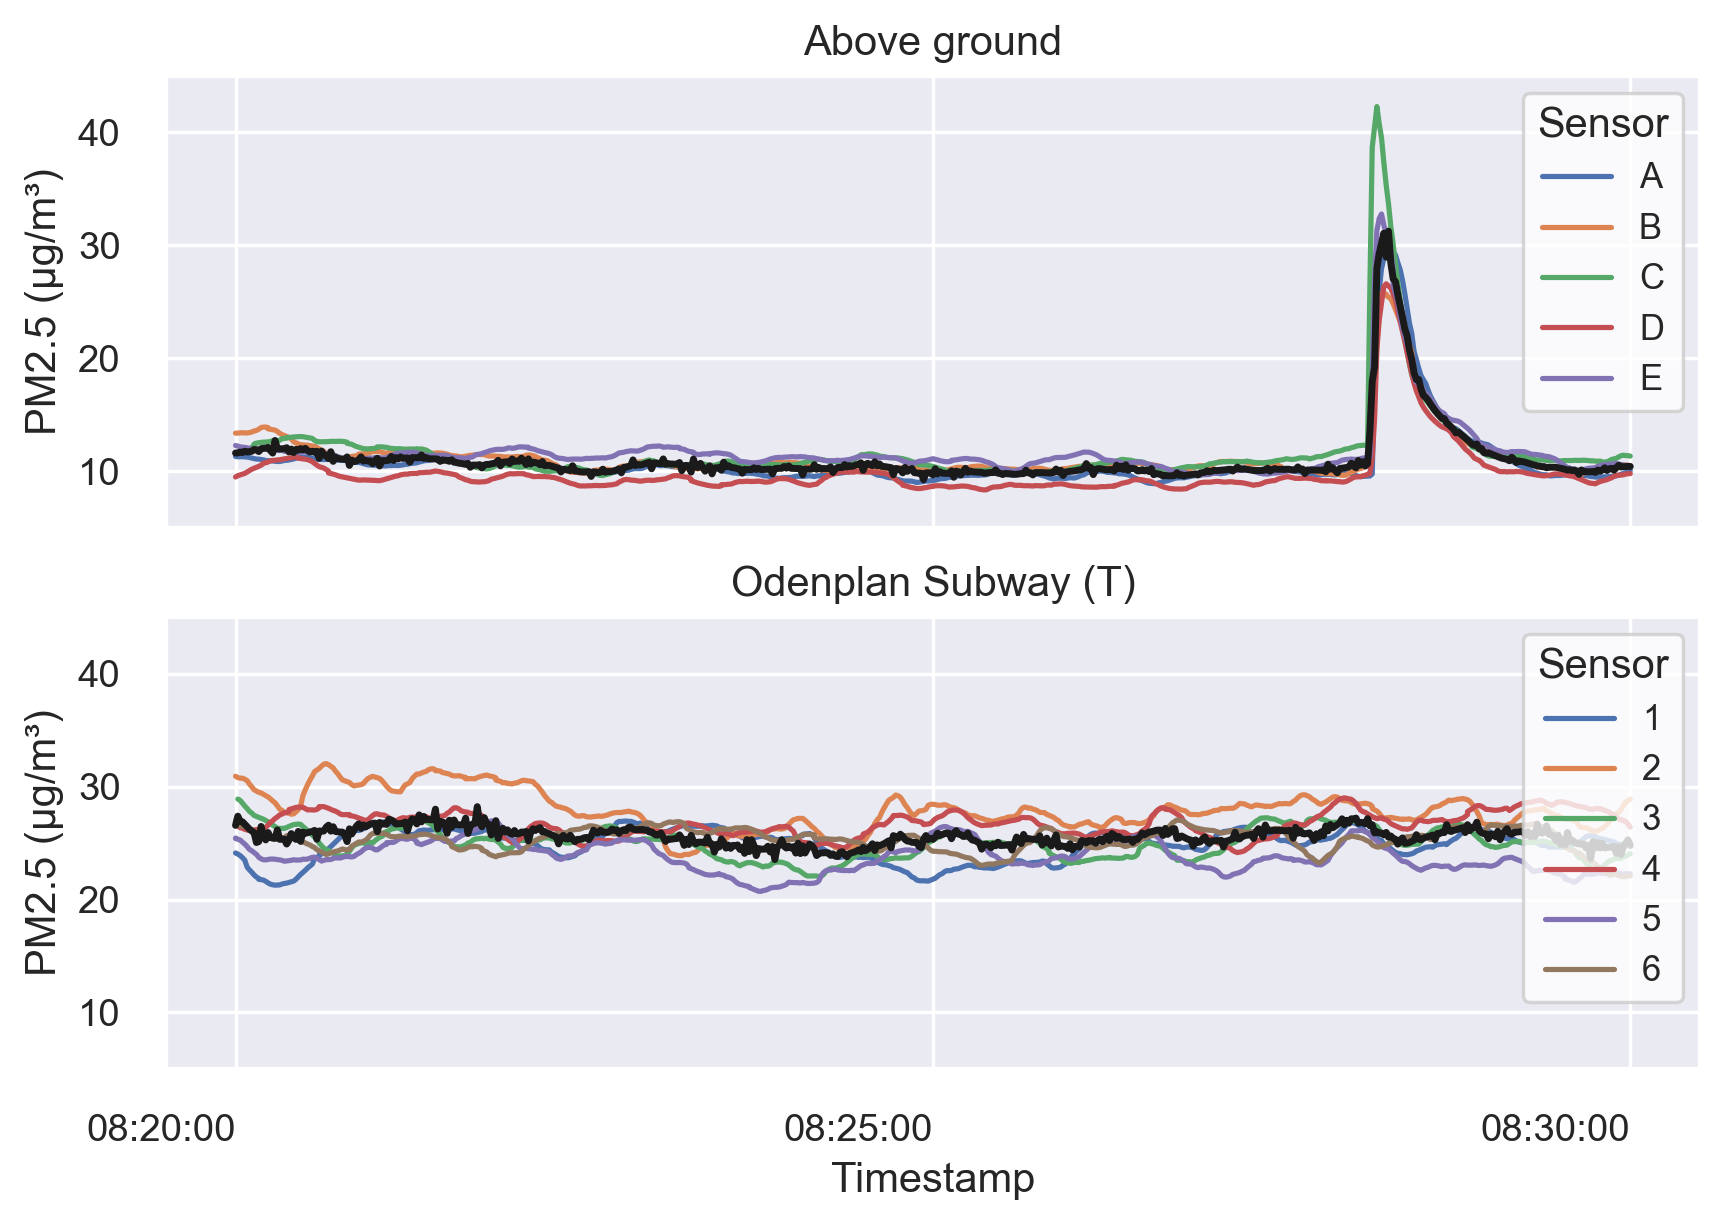

In [27]:
graph_name = f'{fig_folder}/above_vs_odenplanT_mean.pdf'
compare_plot(s1_g1, s1_g2, 'Above ground', 'Odenplan Subway (T)', file_name=graph_name)

Figure saved to ../results/down_middle_up/odenplanP_vs_odenplanT_mean.pdf


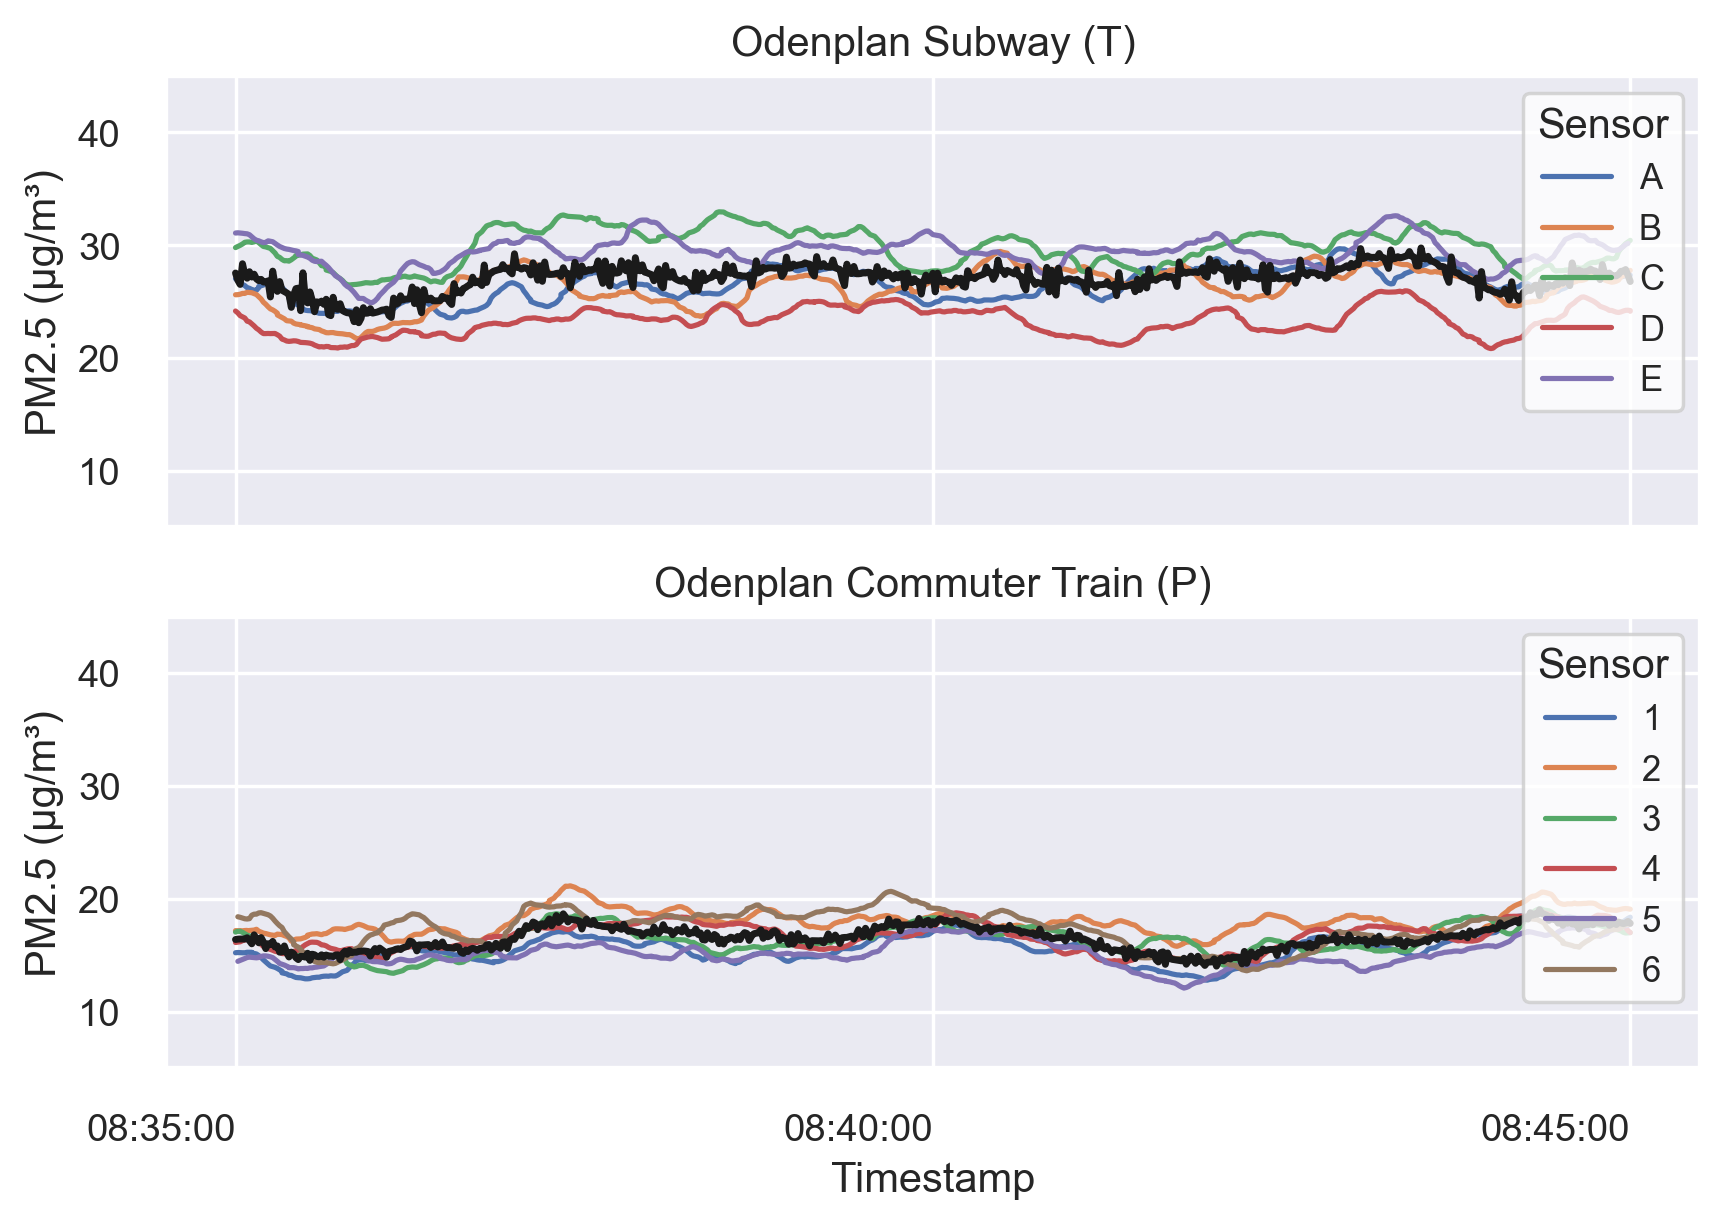

In [28]:
graph_name = f'{fig_folder}/odenplanP_vs_odenplanT_mean.pdf'
compare_plot(s2_g1, s2_g2, 'Odenplan Subway (T)', 'Odenplan Commuter Train (P)', file_name=graph_name)

In [13]:
# Significant difference?
print(f"{s2_g1['PM2.5'].mean()}±{round(CI95(s2_g1['PM2.5'].values), 4)}")

27.025014275517492±0.1041


In [14]:
print(f"{s2_g2['PM2.5'].mean()}±{round(CI95(s2_g2['PM2.5'].values), 4)}")

16.492692421991087±0.0547


In [18]:
significance_level = 0.01
columns = ['Category', 'param', 'n1', 'n2', 'p-value', 'a', 'significant difference']

category = 'T vs. P'
test_rows = []

a = s2_g1['PM2.5'].to_numpy()
b = s2_g2['PM2.5'].to_numpy()

n1 = len(a)
n2 = len(b)

result = stats.ttest_ind(a=a, b=b, equal_var=True)
significant_difference = result.pvalue < significance_level

test_rows.append([category, param, n1, n2, result.pvalue, significance_level, significant_difference])
test_df = pd.DataFrame(test_rows, columns=columns)

test_df

,Category,param,n1,n2,p-value,a,significant difference
0,T vs. P,PM2.5,2802,3365,0.0,0.01,True


In [36]:
# How much do the sensors differ from the mean line?

diffs = {}

for timestamp, grp in s2_g2.groupby('Timestamp'):
    stamp_mean = grp[param].mean()
    
    for sensor, sensor_grp in grp.groupby('Sensor'):
        if sensor not in diffs:
            diffs[sensor] = []
        
        diffs[sensor].append(sensor_grp.iloc[0][param] - stamp_mean)

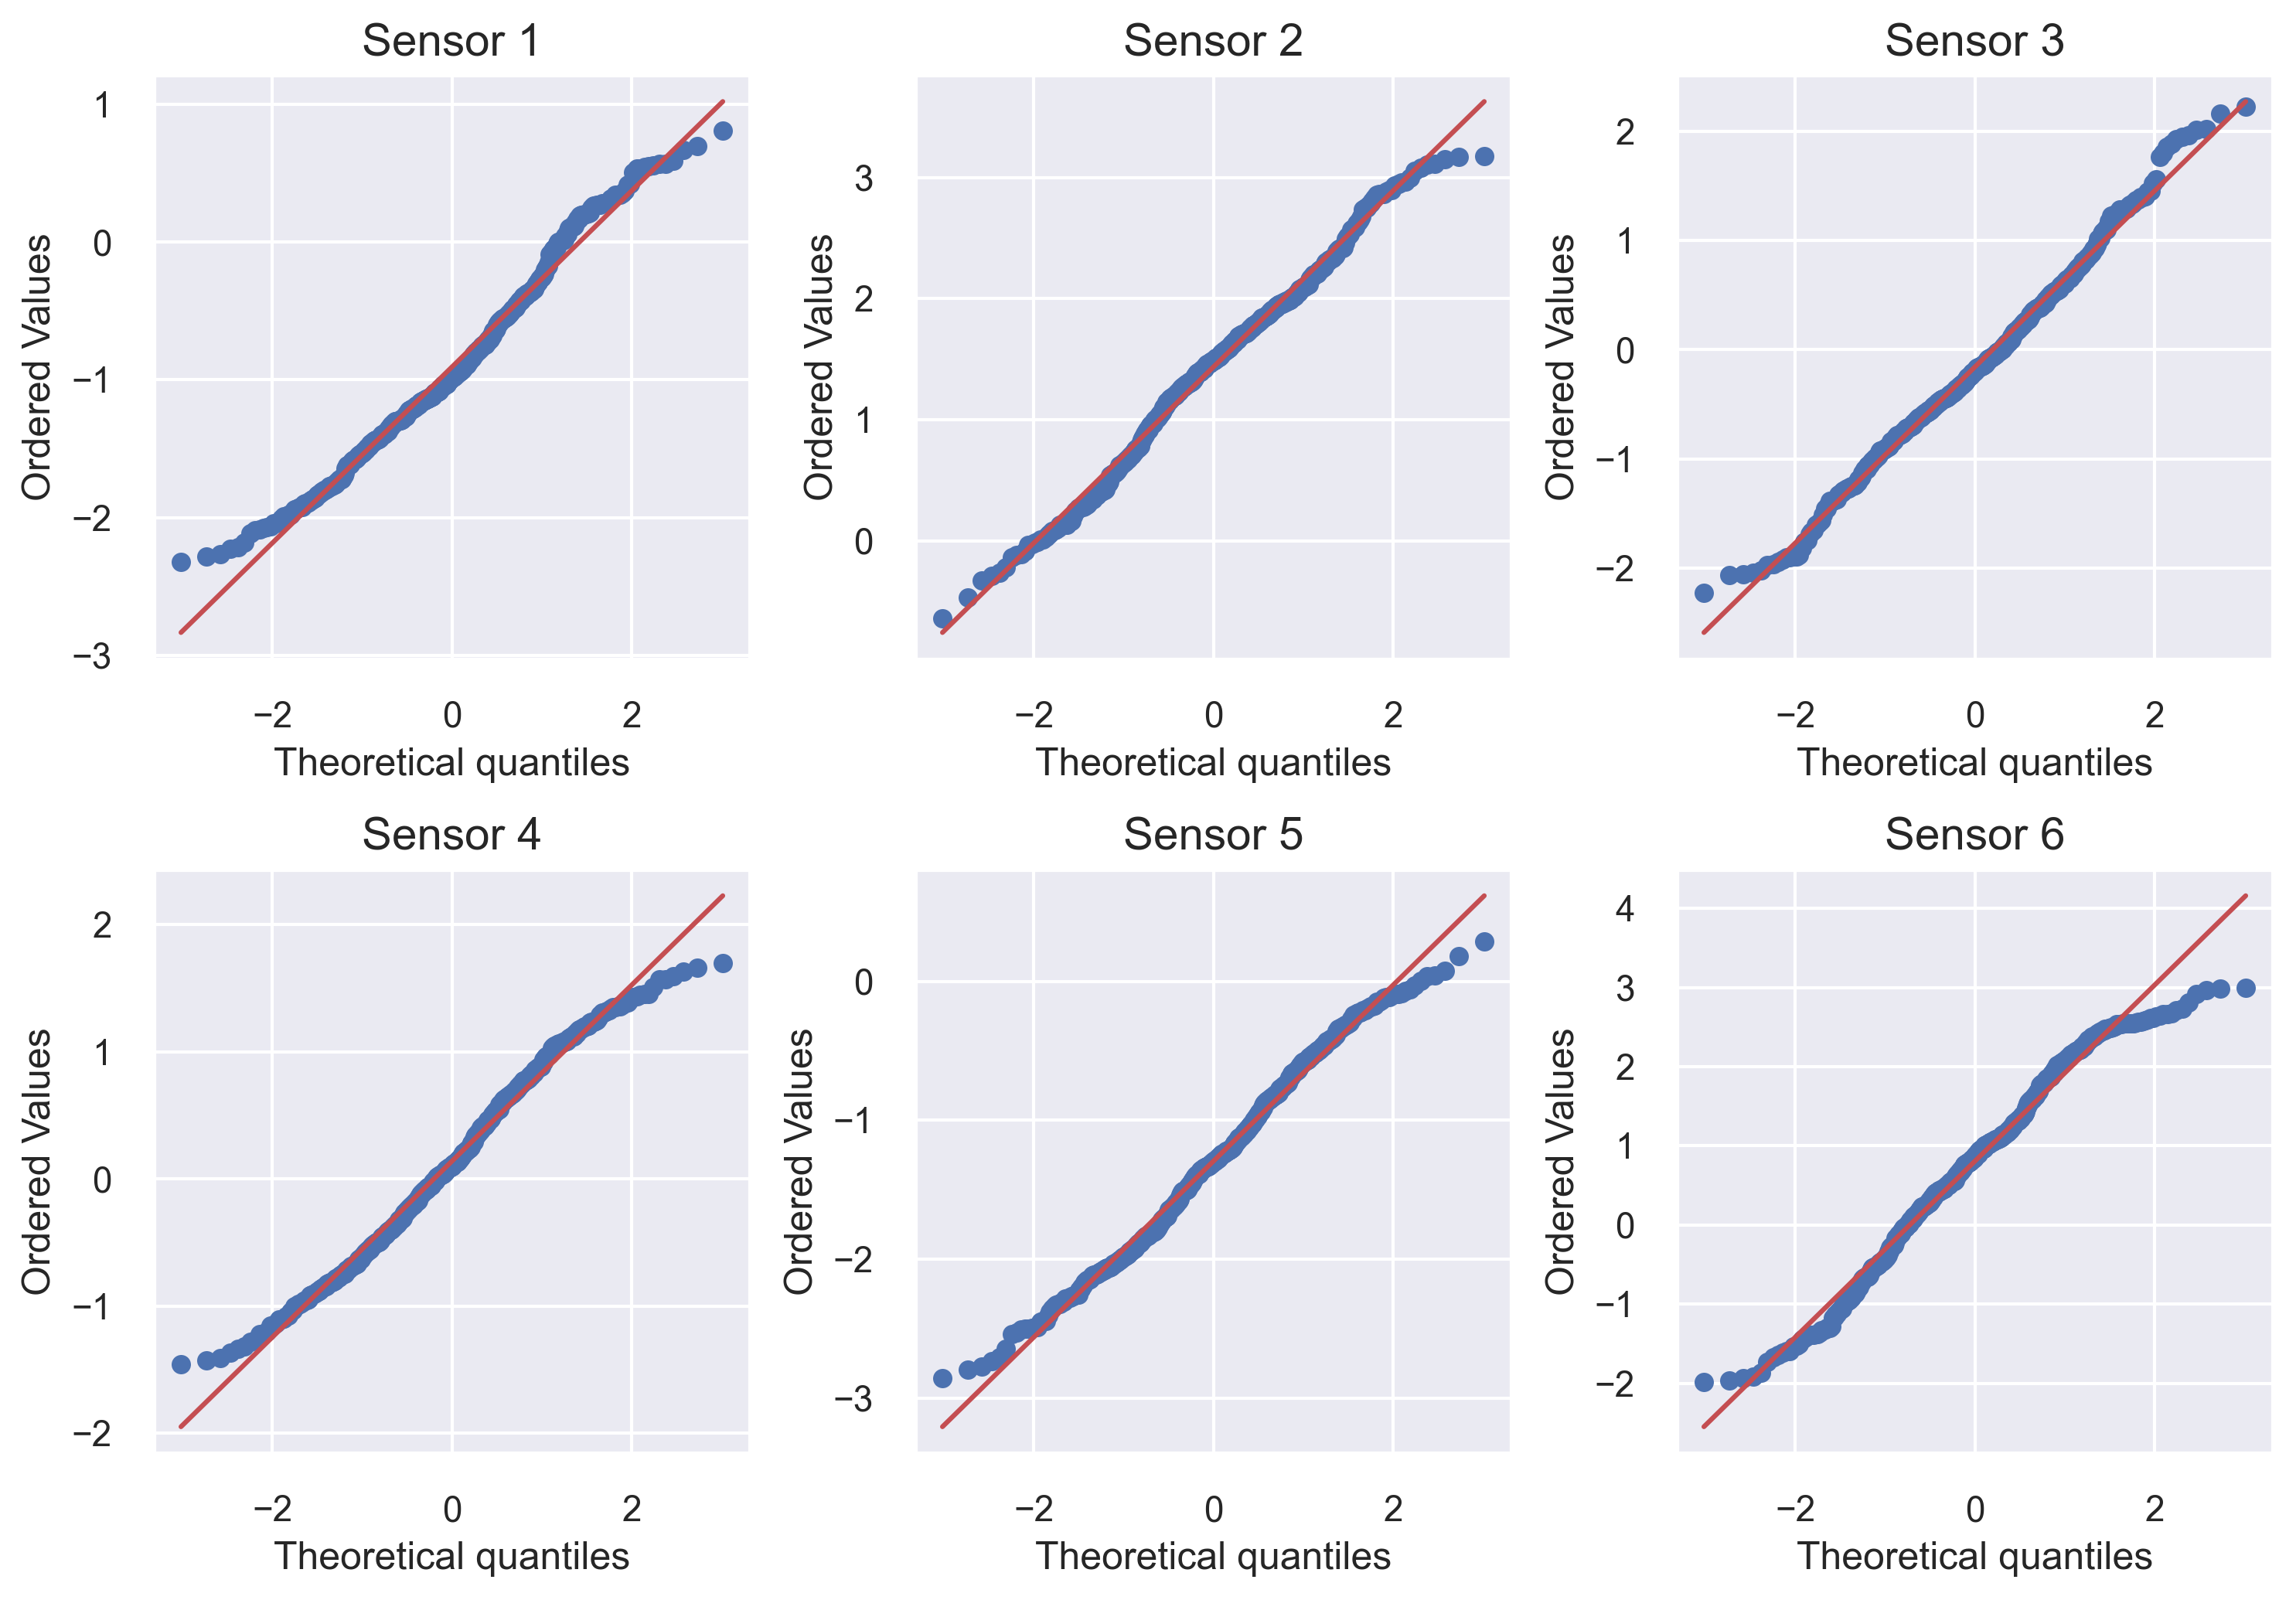

In [37]:
fig, axs = plt.subplots(ncols=3, nrows=2, figsize=[10, 7], dpi=300)

for sensor, ax in zip(s2_g2['Sensor'].unique(), axs.flatten()):
    stats.probplot(diffs[sensor], dist="norm", plot=ax)
    ax.set_title(f"Sensor {sensor}", fontsize=14)

#plt.suptitle('QQ Plots Diffs', fontsize=16)
plt.tight_layout()

fig_name=f'{fig_folder}/sensirion_diffs_qqplots({param}).pdf'
#if fig_name:
#    plt.savefig(fig_name, dpi=300, bbox_inches="tight")

plt.show()